In [1]:
%%capture
!mamba install -y -c conda-forge tensorflow stardist
!pip install cellpose

In [8]:
import sys
!pip install Cython pyimagej
!sudo apt-get install maven
import imagej.convert as convert
import imagej
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
!pip install csbdeep
from csbdeep.utils import normalize
!pip install stardist
from stardist.models import StarDist2D

# initialize ImageJ
mode = "interactive"
if sys.platform == "darwin":
    mode = "headless"

ij = imagej.init(mode=mode)
print(f"ImageJ2 version: {ij.getVersion()}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaopalliance-java libapache-pom-java libatinject-jsr330-api-java
  libcdi-api-java libcommons-cli-java libcommons-io-java libcommons-lang3-java
  libcommons-parent-java libgeronimo-annotation-1.3-spec-java
  libgeronimo-interceptor-3.0-spec-java libguava-java libguice-java
  libhawtjni-runtime-java libjansi-java libjansi-native-java libjsr305-java
  libmaven-parent-java libmaven-resolver-java libmaven-shared-utils-java
  libmaven3-core-java libplexus-cipher-java libplexus-classworlds-java
  libplexus-component-annotations-java libplexus-interpolation-java
  libplexus-sec-dispatcher-java libplexus-utils2-java libsisu-inject-java
  libsisu-plexus-java libslf4j-java libwagon-file-java
  libwagon-http-shaded-java libwagon-provider-api-java
Suggested packages:
  libaopalliance-java-doc libatinject-jsr330-api-java-doc libel-api-java
  libco

In [9]:
def filter_index_image(narr: np.ndarray, min_size:int, max_size:int):
    """
    Filter an index image's labels with a pixel size range.
    """
    unique = np.unique(narr)
    for label in unique:
        if label == 0:
            # skip the background
            continue

        # create a crop for each label
        bbox = get_bounding_box(np.where(narr == label))
        bbox_crop = narr[bbox[0]:bbox[2] + 1, bbox[1]:bbox[3] + 1].copy()
        bbox_crop[bbox_crop != label] = 0

        # get the number of pixels in label
        bbox_crop = bbox_crop.astype(bool)
        label_size = np.sum(bbox_crop)

        if not min_size <= label_size <= max_size:
            narr[narr == label] = 0

    return narr

def get_bounding_box(indices: np.ndarray):
    """
    Get the bounding box coordinates from a the label indices.
    """
    # get min and max bounds of indices array
    min_row = np.min(indices[0])
    min_col = np.min(indices[1])
    max_row = np.max(indices[0])
    max_col = np.max(indices[1])

    return (min_row, min_col, max_row, max_col)

[java.lang.Enum.toString] [INFO] Populating metadata


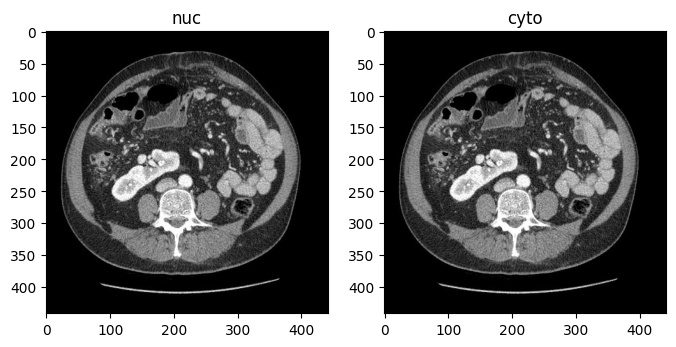

In [21]:
# open image data and convert to Python from Java
data = ij.io().open('/content/drive/MyDrive/ct.jpeg')
xdata = ij.py.from_java(data)

# create a matplotlib subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# show each channel in each column of the matplotlib subplot
# xdata's image dimensions are: (row, col, ch)
axes[0].imshow(xdata[:, :], cmap="gray")
axes[0].set_title('nuc')
axes[1].imshow(xdata[:, :] * 0.05, cmap="gray")
axes[1].set_title('cyto')

# display the plot
plt.show()

In [24]:
# run StarDist on nuclei channel
model = StarDist2D.from_pretrained('2D_versatile_fluo')
nuc_labels, _ = model.predict_instances(normalize(xdata[:, :]))

# run Cellpose on cytoplasm (grayscale)
model = models.CellposeModel(gpu=False, model_type='cyto')
ch = [0, 0]
cyto_labels = model.eval(xdata[:, :].data, channels=ch, diameter=72.1)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


100%|██████████| 25.3M/25.3M [00:00<00:00, 28.6MB/s]


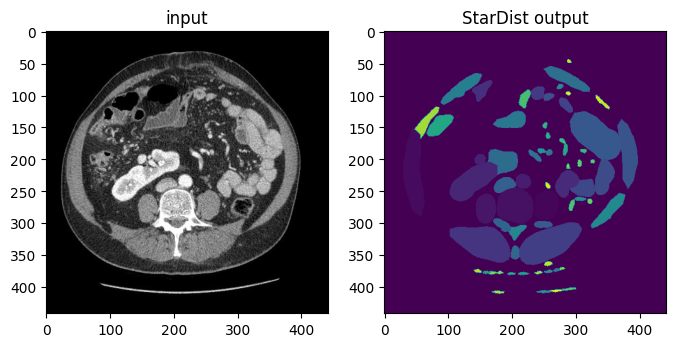

In [26]:
# display StarDist results
fig_n, axes_n = plt.subplots(1, 2, figsize=(8, 5))
axes_n[0].imshow(xdata[:, :], cmap="gray")
axes_n[0].set_title('input')
axes_n[1].imshow(nuc_labels)
axes_n[1].set_title('StarDist output')
plt.show()

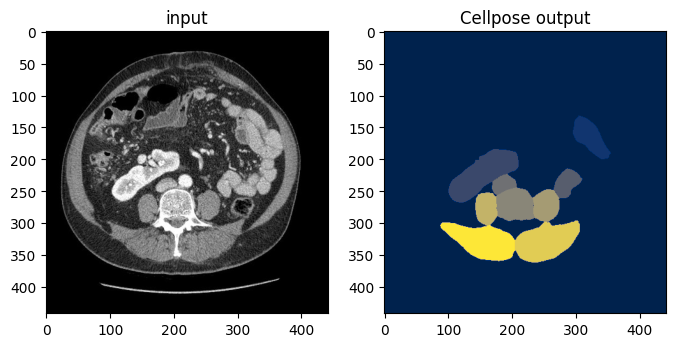

In [29]:
# display cytoplasmic results
fig_c, axes_c = plt.subplots(1, 2, figsize=(8, 5))
axes_c[0].imshow(xdata[:, :] * 0.05, cmap="gray")
axes_c[0].set_title('input')
axes_c[1].imshow(cyto_labels[0], cmap="cividis")
axes_c[1].set_title('Cellpose output')
plt.show()

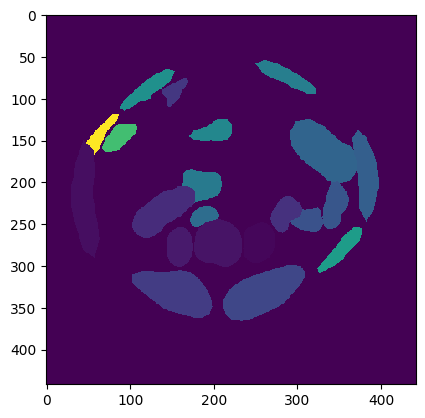

In [30]:
# filter small labels out from the nucleus index image
# by specifiying a pixel size range
ij.py.show(filter_index_image(nuc_labels, 500, 10000))

Text(0.5, 1.0, 'Cellpose output')

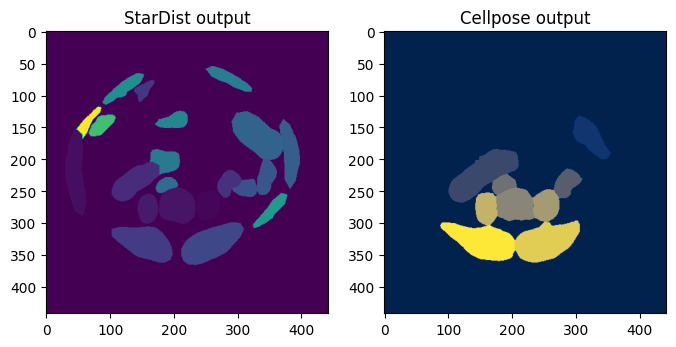

In [31]:
# display StarDist and Cellpose results
fig_c, axes_c = plt.subplots(1, 2, figsize=(8, 5))
axes_c[0].imshow(nuc_labels)
axes_c[0].set_title('StarDist output')
axes_c[1].imshow(cyto_labels[0], cmap="cividis")
axes_c[1].set_title('Cellpose output')